In [1]:
%%time
import inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir) 

from Artha.nlp_extraction import run_pipeline, save_backup, load_backup, to_doc_dict
import Artha.data_process as dp
from Artha.neodb import Neo
import Artha.crypto_data as crypto
from tqdm import tqdm
import json
import numpy as np
np.set_printoptions(suppress=True)
from datetime import datetime, timedelta
from Artha.mentions import *
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import Artha.crypto_data as crypto

# coins database
neo = Neo("neo4j://localhost:7687", "neo4j", "part2")
neo.session.run('''CREATE CONSTRAINT twitter_username IF NOT EXISTS ON (n:Person)
                ASSERT n.username IS UNIQUE''')
neo.session.run('''CREATE CONSTRAINT coin_name IF NOT EXISTS ON (n:Coin)
                ASSERT n.ticker IS UNIQUE''')


CPU times: user 2.54 s, sys: 488 ms, total: 3.02 s
Wall time: 5.04 s


In [2]:
follow_weight = .5
print(len(neo.get_nodes()), len(neo.get_relations()))
# without mentions 711 6958

142 301


In [3]:
neo.clear_nodes()

In [4]:
%%time
# add follows between only people I follow, can change by getting rid of second 2 last line for anyone a person follows

# all_people = [i[1:-4] for i in os.listdir("../data/follows/")]
# checkra_people = [c[3] for c in dp.load_following("checkra_") ]


selected_people = ["BTC_JackSparrow", "Nostranomist", "CryptoKaleo", "nebraskangooner", "Rager", "SavageBTC", "TraderMayne", "IamCryptoWolf", "CryptoNewton"]
selected_nodes = [c for c in dp.load_following("checkra_") if c[3] in selected_people]

selected_follows = dp.follow_edges(selected_people, follow_weight)

CPU times: user 13.7 ms, sys: 4.93 ms, total: 18.7 ms
Wall time: 23.5 ms


In [5]:
%%time
# print(len(follows))
neo.clear_nodes()

neo.load_follow_nodes(selected_nodes)
neo.load_follow_nodes(selected_follows)
neo.load_follow_relations(selected_follows)

print(len(neo.get_nodes()), len(neo.get_relations()))


8 22
CPU times: user 9.38 ms, sys: 3.64 ms, total: 13 ms
Wall time: 758 ms


In [6]:
%%time
# load all tweets
# all_tweets = []
# for ind, username in tqdm(enumerate(selected_people)):
#     cur_tweets = dp.load_tweets(username, location = "../data/tweets1/u")
#     all_tweets.extend([tweet for tweet in dp.clean_tweets(cur_tweets, username)])

# print("\n", len(all_tweets))
# #process all tweets at once
# docs = run_pipeline(all_tweets)
# 

docs = load_backup()
doc_dict = to_doc_dict(docs)

loaded
100%|██████████| 19935/19935 [00:00<00:00, 138436.53it/s]CPU times: user 7.66 s, sys: 205 ms, total: 7.87 s
Wall time: 7.91 s



In [26]:
%%time
# code for multiple graphs over time
day_scores = {}
start_date, window_count = "03/01/2021 00:00:00", 63

dates = [from_datetime(to_datetime(start_date)+timedelta(days=i)) for i in range(window_count)]

for date in tqdm(dates):
    all_mentions = [edge for person in selected_people 
                    for edge in get_mention_edges(
                                      doc_dict[person], person,
                                      follow_weight = follow_weight,
                                      win_start_date = date)]
    neo.clear_nodes("Coin")
    neo.load_mentions(all_mentions)
    day_scores[date] = neo.pagerank_scores()

all_ticks = list(set([tick[0] for day in dates for tick in day_scores[day]]))

tick_dict = {tick: np.zeros(window_count) for tick in all_ticks}

for ind, day in enumerate(day_scores.keys()):
    for score in day_scores[day]:
        tick_dict[score[0]][ind] = score[1]

pdrank = pd.DataFrame(tick_dict, index = pd.to_datetime(dates))


100%|██████████| 63/63 [00:39<00:00,  1.58it/s]CPU times: user 30 s, sys: 339 ms, total: 30.4 s
Wall time: 39.8 s



In [32]:
i = 0
ticker = "DOGE"

while i<len(dates)-1:
    if pdrank[ticker][i]!=0:
        di = pdrank[ticker][i+1]/pdrank[ticker][i]
        if di> 1.1:
            print(i, di, pdrank[ticker][i+1], pdrank[ticker][i])
            print(pdrank[ticker].index[i+1])
    else:
        if pdrank[ticker][i+1] > 0:
            print("new", i, pdrank[ticker][i+1])
    i+=1

# for ind, i in enumerate():
#     print(i)

19 1.361589727432839 0.40743010323494677 0.2992311817768495
2021-03-21 00:00:00
37 1.1129274335712471 0.34947698938776744 0.3140159716131166
2021-04-08 00:00:00
38 1.1364036224517386 0.39714691670378677 0.34947698938776744
2021-04-09 00:00:00
43 1.1609776920790922 0.4684621488209814 0.4035065893316641
2021-04-14 00:00:00
44 1.3962466145588908 0.6540886893402785 0.4684621488209814
2021-04-15 00:00:00
46 3.5162700927937185 2.517420340236276 0.7159348610322922
2021-04-17 00:00:00
49 1.2078835018888276 3.260019909217954 2.6989522616378965
2021-04-20 00:00:00


CPU times: user 86.5 ms, sys: 3.84 ms, total: 90.3 ms
Wall time: 1.2 s


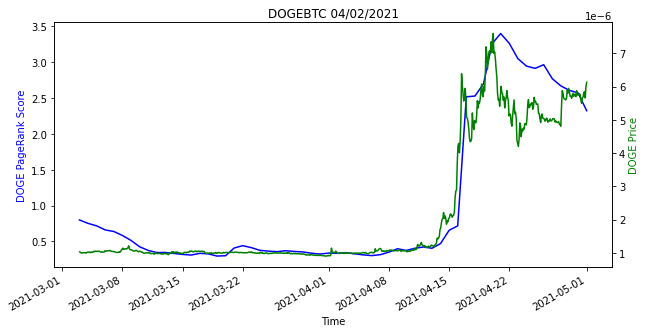

In [33]:
%%time
inc = 32
wind = 30
if ticker == "BTC":
    asset = ticker+"USDT"
else:
    asset = ticker+"BTC"

interval = '2h'
newest, oldest = pdrank[ticker].index[inc-wind: inc+wind][-1].to_pydatetime().timestamp() * 1000, pdrank[ticker].index[inc-wind: inc+wind][0].to_pydatetime().timestamp() * 1000, 
klines = crypto.get_klines(asset, interval, oldest, newest)
df = crypto.get_klines_df(klines)


plt.rcParams['figure.figsize'] = [10, 5]
ts = df["Close"].astype(float) #.pct_change()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


ax1.plot(pdrank[ticker].index[inc-wind: inc+wind], pdrank[ticker][inc-wind: inc+wind], color='b')

ax2.plot(ts.index, ts, color='g')

ax1.set_xlabel('Time')
ax1.set_ylabel(ticker+" PageRank Score", color='b')
ax2.set_ylabel(ticker +" Price", color='g')
# plt.plot([inc]*2, range(-1,1))
plt.title(asset+" "+from_datetime(pdrank[ticker].index[inc].to_pydatetime())[:-9])
plt.gcf().autofmt_xdate()